In [4]:
# === prerequisites ===
# pip install imbalanced-learn xgboost optuna openml

import pandas as pd
import numpy as np
import optuna
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

# 1) Load and assemble
dataset = fetch_openml(data_id=697, as_frame=True)
X = dataset.data
y = dataset.target.astype(float)
df = pd.concat([X, y.rename('target')], axis=1)

# 2) Create quantile bins (e.g. 5 bins)
df['target_bin'] = pd.qcut(df['target'], q=5, duplicates='drop')

# 3) Check bin counts
print("Bin counts:")
print(df['target_bin'].value_counts().sort_index())

# 4) Stratified split on the binned target
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['target_bin'],
    random_state=42
)

# 5) Drop the bin column before modeling
train_df = train_df.drop(columns='target_bin')
test_df  = test_df.drop(columns='target_bin')

print("\nTrain/Test sizes:", train_df.shape, test_df.shape)
print("Train target distribution by bin:")
print(pd.qcut(train_df['target'], q=5).value_counts().sort_index())

Bin counts:
target_bin
(10534.999, 12884.0]    10
(12884.0, 14861.0]       9
(14861.0, 17949.0]       9
(17949.0, 21371.0]       9
(21371.0, 27837.0]       9
Name: count, dtype: int64

Train/Test sizes: (36, 4) (10, 4)
Train target distribution by bin:
target
(10534.999, 12884.0]    8
(12884.0, 14861.0]      7
(14861.0, 17949.0]      7
(17949.0, 21371.0]      7
(21371.0, 27837.0]      7
Name: count, dtype: int64


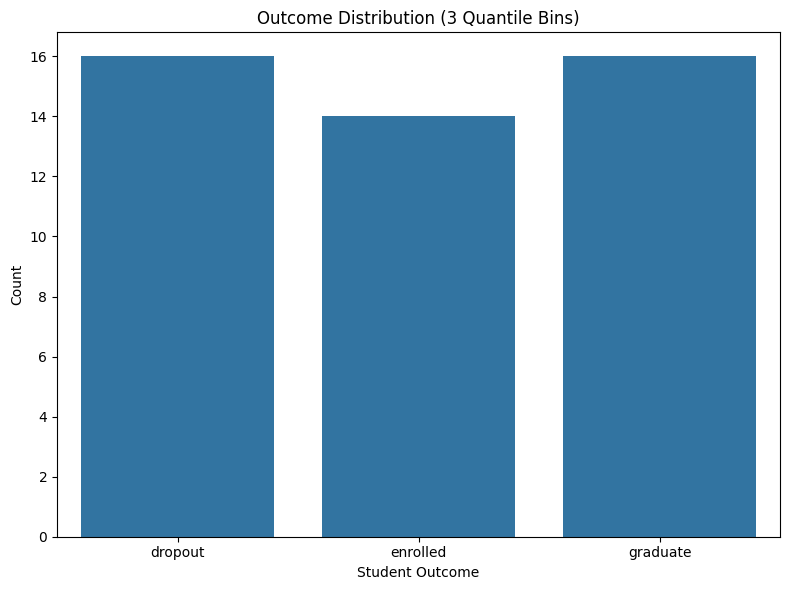

Current counts per outcome:
outcome
dropout     16
enrolled    14
graduate    16
Name: count, dtype: int64

Additional samples needed to reach 16 in each bin:
outcome
dropout     0
enrolled    2
graduate    0
Name: count, dtype: int64


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Create 3 quantile‐based bins and label them
df['outcome'] = pd.qcut(
    df['target'],
    q=3,
    labels=['dropout', 'enrolled', 'graduate']
)

# 2) Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(
    x='outcome',
    data=df,
    order=['dropout', 'enrolled', 'graduate']
)
plt.title('Outcome Distribution (3 Quantile Bins)')
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3) Compute and print counts per bin
counts = df['outcome'].value_counts().sort_index()
print("Current counts per outcome:")
print(counts)

# 4) Compute how many more you’d need to balance all bins to the largest size
max_count = counts.max()
needed = max_count - counts
print("\nAdditional samples needed to reach", max_count, "in each bin:")
print(needed)


In [44]:
from imblearn.over_sampling import SMOTENC

# 1) Prepare X,y
X = df.drop(columns=['target', 'outcome', 'target_bin'])
y = df['outcome']

# 2) Identify which columns are categorical
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
cat_indices = [X.columns.get_loc(c) for c in cat_cols]

# 3) SMOTENC specifying those categorical feature indices
sm = SMOTENC(
    categorical_features=cat_indices,
    sampling_strategy={'enrolled': 16},
    random_state=42
)
X_res, y_res = sm.fit_resample(X, y)

# 4) Verify
print(pd.Series(y_res).value_counts())


outcome
dropout     16
enrolled    16
graduate    16
Name: count, dtype: int64


In [24]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [60]:
# — 1) Prepare your test set (only drop the columns that actually exist)
X_test = test_df.drop(columns=['target', 'outcome'])
y_test = test_df['outcome']

# — 2) Encode your string labels into 0/1/2 for all tree models
label_map = {'dropout': 0, 'enrolled': 1, 'graduate': 2}
y_res_enc  = y_res.map(label_map)
y_test_enc = y_test.map(label_map)

# — 3) One-hot encode features so train & test share the same columns
X_res_enc  = pd.get_dummies(X_res,  drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True) \
                 .reindex(columns=X_res_enc.columns, fill_value=0)

# — 4) Set up a 3-fold stratified CV splitter
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# — 5) Optuna objective functions MUST use the numeric y_res_enc now:

def tune_xgb(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 50, 300),
        'max_depth':        trial.suggest_int('max_depth', 2, 12),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma':            trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'eval_metric':      'logloss',
        'random_state':     42
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_res_enc, y_res_enc, cv=cv, scoring='accuracy').mean()


def tune_lgb(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 50, 300),
        'max_depth':        trial.suggest_int('max_depth', 2, 12),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves':       trial.suggest_int('num_leaves', 20, 200),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state':     42
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X_res_enc, y_res_enc, cv=cv, scoring='accuracy').mean()


def tune_cat(trial):
    params = {
        'iterations':    trial.suggest_int('iterations', 50, 300),
        'depth':         trial.suggest_int('depth', 2, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg':   trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'random_seed':   42,
        'logging_level': 'Silent'
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X_res_enc, y_res_enc, cv=cv, scoring='accuracy').mean()


# — 6) Run the studies
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(tune_xgb, n_trials=20)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(tune_lgb, n_trials=20)

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(tune_cat, n_trials=20)

# — 7) Extract best-found params
best_xgb_params = study_xgb.best_params
best_lgb_params = study_lgb.best_params
best_cat_params = study_cat.best_params

print("🎯 Best XGB params:", best_xgb_params)
print("🎯 Best LGB params:", best_lgb_params)
print("🎯 Best CAT params:", best_cat_params)

# — 8) Instantiate tuned models
best_xgb = XGBClassifier(**best_xgb_params, use_label_encoder=False,
                        eval_metric='logloss', random_state=42)
best_lgb = LGBMClassifier(**best_lgb_params, random_state=42)
best_cat = CatBoostClassifier(**best_cat_params, random_seed=42,
                              logging_level='Silent')

[I 2025-04-28 02:55:36,932] A new study created in memory with name: no-name-befb0459-21d6-41b3-aaaa-0c4ed5be789f
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:55:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-28 02:55:37,141] Trial 0 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.027794968070466365, 'subsample': 0.8154807272916058, 'colsample_bytree': 0.5773151541385257, 'gamma':

🎯 Best XGB params: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.002713345129264609, 'subsample': 0.9125764549033646, 'colsample_bytree': 0.6914397494057629, 'gamma': 0.00188038580364912}
🎯 Best LGB params: {'n_estimators': 59, 'max_depth': 4, 'learning_rate': 0.0013978545576808824, 'num_leaves': 155, 'subsample': 0.7478151428053649, 'colsample_bytree': 0.5167841468683482}
🎯 Best CAT params: {'iterations': 56, 'depth': 11, 'learning_rate': 0.02269184262255304, 'l2_leaf_reg': 3.230596860089227e-08}


In [73]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

# 1) Re-instantiate each model with silent/quiet settings
best_xgb = XGBClassifier(
    **xgb_params,
    use_label_encoder=False   # still ignored in recent versions, but OK to include
)

best_lgb = LGBMClassifier(
    **lgb_params,
)

best_cat = CatBoostClassifier(
    **cat_params,
)

# 2) Fit each on the full SMOTENC training set
best_xgb.fit(X_res_enc, y_res_enc)
best_lgb.fit(X_res_enc, y_res_enc)
best_cat.fit(X_res_enc, y_res_enc)

# 3) Individual model evaluation
for name, model in [
    ("XGBoost", best_xgb),
    ("LightGBM", best_lgb),
    ("CatBoost", best_cat),
]:
    y_pred = model.predict(X_test_enc)
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test_enc, y_pred))
    print(classification_report(
        y_test_enc, y_pred,
        target_names=list(label_map.keys())
    ))

# 4) Soft-voting ensemble (still silent)
voting = VotingClassifier(
    estimators=[("xgb", best_xgb), ("lgb", best_lgb), ("cat", best_cat)],
    voting="soft",
    n_jobs=-1
)
voting.fit(X_res_enc, y_res_enc)
y_v = voting.predict(X_test_enc)
print("\n--- Voting Ensemble ---")
print("Accuracy:", accuracy_score(y_test_enc, y_v))
print(classification_report(
    y_test_enc, y_v,
    target_names=list(label_map.keys())
))

# 5) Stacking ensemble, with fewer folds and parallel jobs
stack = StackingClassifier(
    estimators=[("xgb", best_xgb), ("lgb", best_lgb), ("cat", best_cat)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3‐fold instead of 5
    n_jobs=-1                                                        # parallelize
)
stack.fit(X_res_enc, y_res_enc)
y_s = stack.predict(X_test_enc)
print("\n--- Stacking Ensemble ---")
print("Accuracy:", accuracy_score(y_test_enc, y_s))
print(classification_report(
    y_test_enc, y_s,
    target_names=list(label_map.keys())
))



--- XGBoost ---
Accuracy: 0.9
              precision    recall  f1-score   support

     dropout       1.00      0.75      0.86         4
    enrolled       0.67      1.00      0.80         2
    graduate       1.00      1.00      1.00         4

    accuracy                           0.90        10
   macro avg       0.89      0.92      0.89        10
weighted avg       0.93      0.90      0.90        10


--- LightGBM ---
Accuracy: 0.9
              precision    recall  f1-score   support

     dropout       1.00      0.75      0.86         4
    enrolled       0.67      1.00      0.80         2
    graduate       1.00      1.00      1.00         4

    accuracy                           0.90        10
   macro avg       0.89      0.92      0.89        10
weighted avg       0.93      0.90      0.90        10


--- CatBoost ---
Accuracy: 1.0
              precision    recall  f1-score   support

     dropout       1.00      1.00      1.00         4
    enrolled       1.00      1.00 

In [74]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# 1) Define your 5-fold splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) List out the models you want to compare
models = [
    ('XGBoost', best_xgb),
    ('LightGBM', best_lgb),
    ('CatBoost', best_cat),
    ('VotingEnsemble', voting),   # if you’ve already built voting
    ('StackingEnsemble', stack)   # if you’ve already built stacking
]

# 3) Choose the metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 4) Run cross-validation
for name, model in models:
    print(f"\n=== {name} (5-fold CV) ===")
    cv_results = cross_validate(
        model,
        X_res_enc,
        y_res_enc,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric.capitalize():<12}: {scores.mean():.3f} ± {scores.std():.3f}")



=== XGBoost (5-fold CV) ===
Accuracy    : 0.856 ± 0.078
Precision_macro: 0.884 ± 0.064
Recall_macro: 0.861 ± 0.070
F1_macro    : 0.854 ± 0.074

=== LightGBM (5-fold CV) ===
Accuracy    : 0.836 ± 0.077
Precision_macro: 0.874 ± 0.063
Recall_macro: 0.839 ± 0.067
F1_macro    : 0.833 ± 0.071

=== CatBoost (5-fold CV) ===
Accuracy    : 0.856 ± 0.100
Precision_macro: 0.891 ± 0.080
Recall_macro: 0.861 ± 0.093
F1_macro    : 0.856 ± 0.098

=== VotingEnsemble (5-fold CV) ===
Accuracy    : 0.836 ± 0.077
Precision_macro: 0.874 ± 0.063
Recall_macro: 0.839 ± 0.067
F1_macro    : 0.833 ± 0.071

=== StackingEnsemble (5-fold CV) ===
Accuracy    : 0.836 ± 0.077
Precision_macro: 0.874 ± 0.063
Recall_macro: 0.839 ± 0.067
F1_macro    : 0.833 ± 0.071
